<a href="https://colab.research.google.com/github/millandmills/homework/blob/main/homework%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1: 5
2: 4
масштабирование формы (2, 2)
среднее максимума 8.448794593320889 квантиль 0.95 11.808593153196732
шейп: (70000, 29)
Колонки: ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
Ссамая частая причина отмены: A
CancellationCode
A    563
B    549
C    299
Name: count, dtype: int64

7) дистанция mean/min/max:
 mean     724.508257
min       31.000000
max     4962.000000
Name: Distance, dtype: float64

8) Минимальная дистанция: 31.0
рейсы с минимальной дистанцией:
       Year  Month  DayofMonth UniqueCarrier  FlightNum Origin Dest  Distance
1116   2008     12          30            AS         65    WRG  PSG        31
6958   2008     12          26     

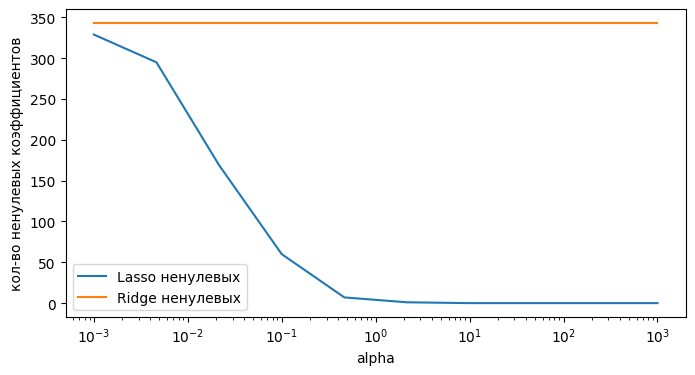

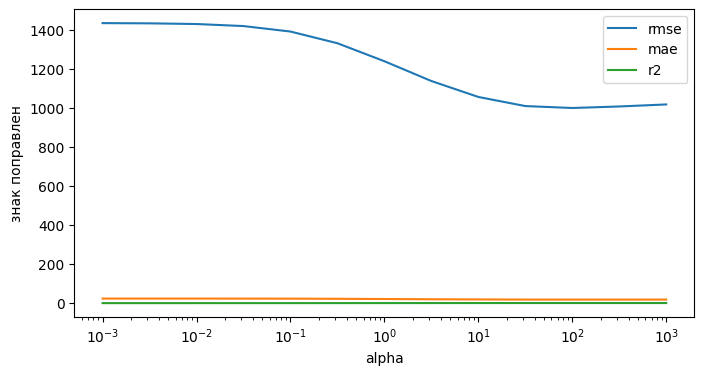

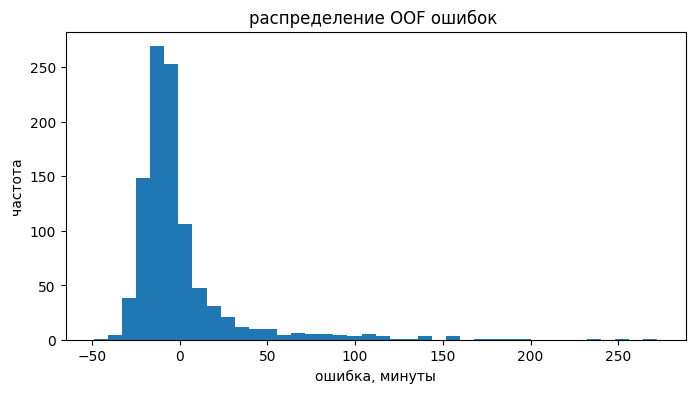

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge

plt.rcParams['figure.figsize'] = (10, 5)
np.set_printoptions(suppress=True)

DATA_PATH = '/content/2008.csv'

def max_element(arr: np.ndarray):
    arr = np.asarray(arr)
    if arr.ndim != 1:
        raise ValueError('Ожидается одномерный массив')
    mask = arr[:-1] == 0
    if not mask.any():
        return None
    return arr[1:][mask].max()

def nearest_value(X: np.ndarray, v: float):
    X = np.asarray(X)
    flat = X.ravel()
    idx = np.argmin(np.abs(flat - v))
    return flat[idx]

def scale(X: np.ndarray):
    X = np.asarray(X, dtype=float)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std_safe = np.where(std == 0, 1.0, std)
    return (X - mean) / std_safe

def get_stats(X: np.ndarray):
    X = np.asarray(X, dtype=float)
    return {
        'determinant': np.linalg.det(X),
        'trace': np.trace(X),
        'min': X.min(),
        'max': X.max(),
        'frobenius_norm': np.linalg.norm(X, 'fro'),
        'eigenvalues': np.linalg.eigvals(X),
        'inverse': np.linalg.inv(X),
    }

rng = np.random.default_rng(42)
A = rng.standard_normal((100, 10, 10))
B = rng.standard_normal((100, 10, 10))
products = np.einsum('bij,bjk->bik', A, B)
max_vals = products.max(axis=(1, 2))
exp_mean = max_vals.mean()
exp_q95 = np.quantile(max_vals, 0.95)

print('1:', max_element(np.array([6, 2, 0, 3, 0, 0, 5, 7, 0])))
print('2:', nearest_value(np.arange(10).reshape(2, 5), 3.6))
print('масштабирование формы', scale(np.array([[1, 2], [1, 5]])).shape)
print('среднее максимума', exp_mean, 'квантиль 0.95', exp_q95)
df = pd.read_csv(DATA_PATH)
print('шейп:', df.shape)
print('Колонки:', df.columns.tolist())
df.head()

cancel_mode = df['CancellationCode'].mode(dropna=True)
most_common_cancel = cancel_mode.iloc[0] if len(cancel_mode) else None
cancel_counts = df['CancellationCode'].value_counts(dropna=True)
print('Ссамая частая причина отмены:', most_common_cancel)
print(cancel_counts)

distance_stats = df['Distance'].agg(['mean', 'min', 'max'])
print('\n7) дистанция mean/min/max:\n', distance_stats)

min_dist = distance_stats['min']
min_rows = df[df['Distance'] == min_dist][['Year','Month','DayofMonth','UniqueCarrier','FlightNum','Origin','Dest','Distance']]
print('\n8) Минимальная дистанция:', min_dist)
print('рейсы с минимальной дистанцией:')
print(min_rows.head())
route_keys = ['UniqueCarrier','FlightNum','Origin','Dest']
other_days = df[df[route_keys].apply(tuple, axis=1).isin(min_rows[route_keys].apply(tuple, axis=1))]
other_dist_summary = other_days.groupby(route_keys)['Distance'].unique()
print('дистанции для тех же рейсов в другие дни:')
print(other_dist_summary.head())

origin_counts = df['Origin'].value_counts()
top_airport = origin_counts.idxmax()
city_col = 'OriginCityName'
top_city = None
if city_col in df.columns:
    top_city = df.loc[df['Origin'] == top_airport, city_col].mode(dropna=True).iloc[0]
print('\n9) больше всего вылетов из:', top_airport, '| город:', top_city)

mean_airtime_by_origin = df.groupby('Origin')['AirTime'].mean()
top_airtime_origin = mean_airtime_by_origin.idxmax()
print('\n10) макс среднее AirTime у аэропорта:', top_airtime_origin,
      ':', mean_airtime_by_origin[top_airtime_origin])

origin_delay = (df.assign(is_delayed=df['DepDelay'] > 0)
                  .groupby('Origin')
                  .agg(total=('DepDelay','size'), delayed=('is_delayed','mean')))
origin_delay_filtered = origin_delay[origin_delay['total'] >= 1000]
worst_origin = origin_delay_filtered['delayed'].idxmax()
print('\n11) наибольшая доля задержек:', worst_origin,
      'доля:', origin_delay_filtered.loc[worst_origin, 'delayed'])
origin_delay_filtered.sort_values('delayed', ascending=False).head()

na_per_feature = df.isna().sum()
total_na = na_per_feature.sum()
rows_with_na = df.isna().any(axis=1).sum()
features_with_na = (na_per_feature > 0).sum()
print('всего пропусков в матрице:', total_na)
print('объектов с >=1 пропуском:', rows_with_na)
print('признаков с пропусками:', features_with_na)


na_target = df['DepDelay'].isna().sum()
print('пропусков в DepDelay - целефой переменной:', na_target)
if {'Cancelled','Diverted'}.issubset(df.columns):
    print(df[df['DepDelay'].isna()][['Cancelled','Diverted']].value_counts())

clean_df = df[~df['DepDelay'].isna() & (df['DepDelay'] != 0)].copy()
y = clean_df['DepDelay']
X = clean_df.drop(columns=['DepDelay'])
print('после фильтрации:', X.shape)
X.head()


def split_time_feature(df_in, feature):
    col = df_in[feature]
    hours = np.floor_divide(col, 100)
    minutes = np.mod(col, 100)
    df_in[f'{feature}_Hour'] = hours
    df_in[f'{feature}_Minute'] = minutes
    df_in.drop(columns=[feature], inplace=True)

X_time = X.copy()
for feat in ['DepTime','CRSDepTime','ArrTime','CRSArrTime']:
    if feat in X_time.columns:
        split_time_feature(X_time, feat)

X_time.head()

leaky_cols = [
    'ArrDelay', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
    'TaxiIn', 'TaxiOut', 'CancellationCode', 'Cancelled', 'Diverted',
    'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
    'ArrTime_Hour', 'ArrTime_Minute', 'CRSArrTime_Hour', 'CRSArrTime_Minute',
    'TailNum', 'Year'
]
cols_to_drop = [c for c in leaky_cols if c in X_time.columns]
X_model = X_time.drop(columns=cols_to_drop)
print('удалено признаков:', len(cols_to_drop))
print('итоговая X_model:', X_model.shape)
X_model.head()


def transform_data(data: pd.DataFrame):
    num_cols = data.select_dtypes(include=[np.number]).columns
    cat_cols = data.columns.difference(num_cols)

    num_part = data[num_cols].copy().fillna(0)
    scaler = StandardScaler()
    num_scaled = scaler.fit_transform(num_part)
    num_df = pd.DataFrame(num_scaled, columns=num_cols, index=data.index)

    cat_part = data[cat_cols].copy()
    if len(cat_cols) > 0:
        cat_part = cat_part.fillna('nan').astype(str)
        cat_df = pd.get_dummies(cat_part, dummy_na=False)
        result = pd.concat([num_df, cat_df], axis=1)
    else:
        result = num_df
    return result

X_prepared = transform_data(X_model)
print('после преобразования признаков:', X_prepared.shape)
X_prepared.head()

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.3, random_state=42, shuffle=True
)
X_train.shape, X_test.shape

subset_n = 1000
sub_X = X_train.iloc[:subset_n]
sub_y = y_train.iloc[:subset_n]
linreg = LinearRegression()
linreg.fit(sub_X, sub_y)

train_pred = linreg.predict(sub_X)
test_pred = linreg.predict(X_test)

mse_train = mean_squared_error(sub_y, train_pred)
r2_train = r2_score(sub_y, train_pred)
mse_test = mean_squared_error(y_test, test_pred)
r2_test = r2_score(y_test, test_pred)

print('MSE train:', mse_train, 'R2 train:', r2_train)
print('MSE test :', mse_test, 'R2 test :', r2_test)

coef_abs = np.abs(linreg.coef_)
print('макс по модулю коэффициент:', coef_abs.max())

alphas = np.logspace(-3, 3, 10)
lasso_nonzero, ridge_nonzero = [], []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000)
    lasso.fit(sub_X, sub_y)
    lasso_nonzero.append((np.abs(lasso.coef_) > 1e-4).sum())

    ridge = Ridge(alpha=a)
    ridge.fit(sub_X, sub_y)
    ridge_nonzero.append((np.abs(ridge.coef_) > 1e-4).sum())

plt.figure(figsize=(8,4))
plt.plot(alphas, lasso_nonzero, label='Lasso ненулевых')
plt.plot(alphas, ridge_nonzero, label='Ridge ненулевых')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('кол-во ненулевых коэффициентов')
plt.legend();

ridge_base = Ridge(alpha=1.0)
ridge_base.fit(sub_X, sub_y)
ridge_pred = ridge_base.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
mae = mean_absolute_error(y_test, ridge_pred)
r2 = r2_score(y_test, ridge_pred)
print('Ridge alpha=1: RMSE', rmse, 'MAE', mae, 'R2', r2)

# Подбор alpha по кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_alphas = np.logspace(-3, 3, 13)
scoring_map = {
    'rmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}
results = {}
for name, scoring in scoring_map.items():
    grid = GridSearchCV(Ridge(), {'alpha': grid_alphas}, scoring=scoring, cv=cv)
    grid.fit(sub_X, sub_y)
    results[name] = grid.cv_results_['mean_test_score']
    best_alpha = grid.best_params_['alpha']
    best_model = grid.best_estimator_
    pred = best_model.predict(X_test)
    if name == 'rmse':
        metric_val = np.sqrt(mean_squared_error(y_test, pred))
    elif name == 'mae':
        metric_val = mean_absolute_error(y_test, pred)
    else:
        metric_val = r2_score(y_test, pred)
    print(f'лучший aльфа для {name}:', best_alpha, 'качество на тесте:', metric_val)

plt.figure(figsize=(8,4))
for name, scores in results.items():
    plt.plot(grid_alphas, -scores if name!='r2' else scores, label=name)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('знак поправлен')
plt.legend();

# 19. Out-of-Fold предсказания и анализ ошибок
best_alpha_rmse = grid_alphas[np.argmax(results['rmse'])]
print('лучший альфа по RMSE:', best_alpha_rmse)

ridge_oof = Ridge(alpha=best_alpha_rmse)
oof_pred = cross_val_predict(ridge_oof, sub_X, sub_y, cv=cv)
errors = sub_y - oof_pred

plt.figure(figsize=(8,4))
plt.hist(errors, bins=40)
plt.title('распределение OOF ошибок ')
plt.xlabel('ошибка, минуты')
plt.ylabel('частота');

print('средняя ошибка:', errors.mean(), 'Std:', errors.std())